In [2]:
import pandas as pd
from os import path


dfs = []

DATA_DIR = path.join(path.pardir, path.pardir, 'data', 'microbenchmark_queues', 'dynamo', 'throughput')
for rps in range(10, 200, 5):
    gen = pd.read_csv(path.join(DATA_DIR, f'generator_{rps}.csv'))
    gen['rps'] = rps
    gen.rename(columns={"time": "timestamp"}, inplace=True)
    recv = pd.read_csv(path.join(DATA_DIR, f'receiver_{rps}.csv'))
    recv['rps'] = rps
    dfs.append(gen)
    dfs.append(recv)

DATA_DIR = path.join(path.pardir, path.pardir, 'data', 'microbenchmark_queues', 'sqs', 'throughput')
for rps in range(10, 200, 5):
    gen = pd.read_csv(path.join(DATA_DIR, f'generator_{rps}.csv'))
    gen['rps'] = rps
    gen.rename(columns={"time": "timestamp"}, inplace=True)
    recv = pd.read_csv(path.join(DATA_DIR, f'receiver_{rps}.csv'))
    recv['rps'] = rps
    dfs.append(gen)
    dfs.append(recv)

DATA_DIR = path.join(path.pardir, path.pardir, 'data', 'microbenchmark_queues', 'sqs_fifo', 'throughput')
for rps in range(10, 200, 5):
    gen = pd.read_csv(path.join(DATA_DIR, f'generator_{rps}.csv'))
    gen['rps'] = rps
    gen.rename(columns={"time": "timestamp"}, inplace=True)
    recv = pd.read_csv(path.join(DATA_DIR, f'receiver_{rps}.csv'))
    recv['rps'] = rps
    dfs.append(gen)
    dfs.append(recv)
    
df = pd.concat(dfs)
df['new_timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('new_timestamp', inplace=True)
df['count'] = 1

In [10]:
#x = df.loc[(df['rps'] == 100) & (df['type'] == 'rtt')]
#x = df.loc[(df['type'] == 'rtt')]
#print(x)rolling('1s')['count'].sum()
#x.groupby(['rps']).rolling('1s')['count'].sum()

#def f(df):
#    df['rps_max'] = df.rolling('1s')['count'].sum().max()
#    return df

#print(x.groupby(['rps']).apply(f))

print(df)

data = []
for typ in ['sqs', 'sqs_fifo', 'dynamo']:
    x = df.loc[(df['type'] == 'rtt') & (df['queue'] == typ)]
    for group_name, df_group in x.groupby(['rps']):
        #print(df_group.rolling('1s')['count'].sum().max())
        rolling = df_group.rolling('1s')['count'].sum()
        data.append([group_name, rolling.mean(), typ, 'mean'])
        data.append([group_name, rolling.median(), typ, 'median'])
        data.append([group_name, rolling.quantile(.99), typ, 'p99'])
        data.append([group_name, rolling.max(), typ, 'max'])

        diff = df_group['timestamp'].max() - df_group['timestamp'].min()
        count = df_group['count'].sum()
        print(count/diff)
        print(rolling.mean())
    
#print(data)
processed_windows = pd.DataFrame(data, columns=['rps', 'val', 'queue', 'type'])
print(processed_windows)
#print(x)
#x['acc_count'] = x.rolling('1s')['count'].sum()
#print(x)

#x.group

                               Unnamed: 0     timestamp       idx     queue  \
new_timestamp                                                                 
2022-02-06 19:31:49.748267264           0  1.644176e+09  0ba82f93    dynamo   
2022-02-06 19:31:49.820467712           1  1.644176e+09  73b82f3a    dynamo   
2022-02-06 19:31:49.920738560           2  1.644176e+09  f0ef5a42    dynamo   
2022-02-06 19:31:50.021791744           3  1.644176e+09  4eba70d9    dynamo   
2022-02-06 19:31:50.121024768           4  1.644176e+09  e0452ba1    dynamo   
...                                   ...           ...       ...       ...   
2022-02-06 18:42:00.961026816        1945  1.644173e+09     40795  sqs_fifo   
2022-02-06 18:42:00.994072064        1946  1.644173e+09     40796  sqs_fifo   
2022-02-06 18:42:00.994842112        1947  1.644173e+09     40797  sqs_fifo   
2022-02-06 18:42:00.995575296        1948  1.644173e+09     40798  sqs_fifo   
2022-02-06 18:42:00.996371456        1949  1.644173e

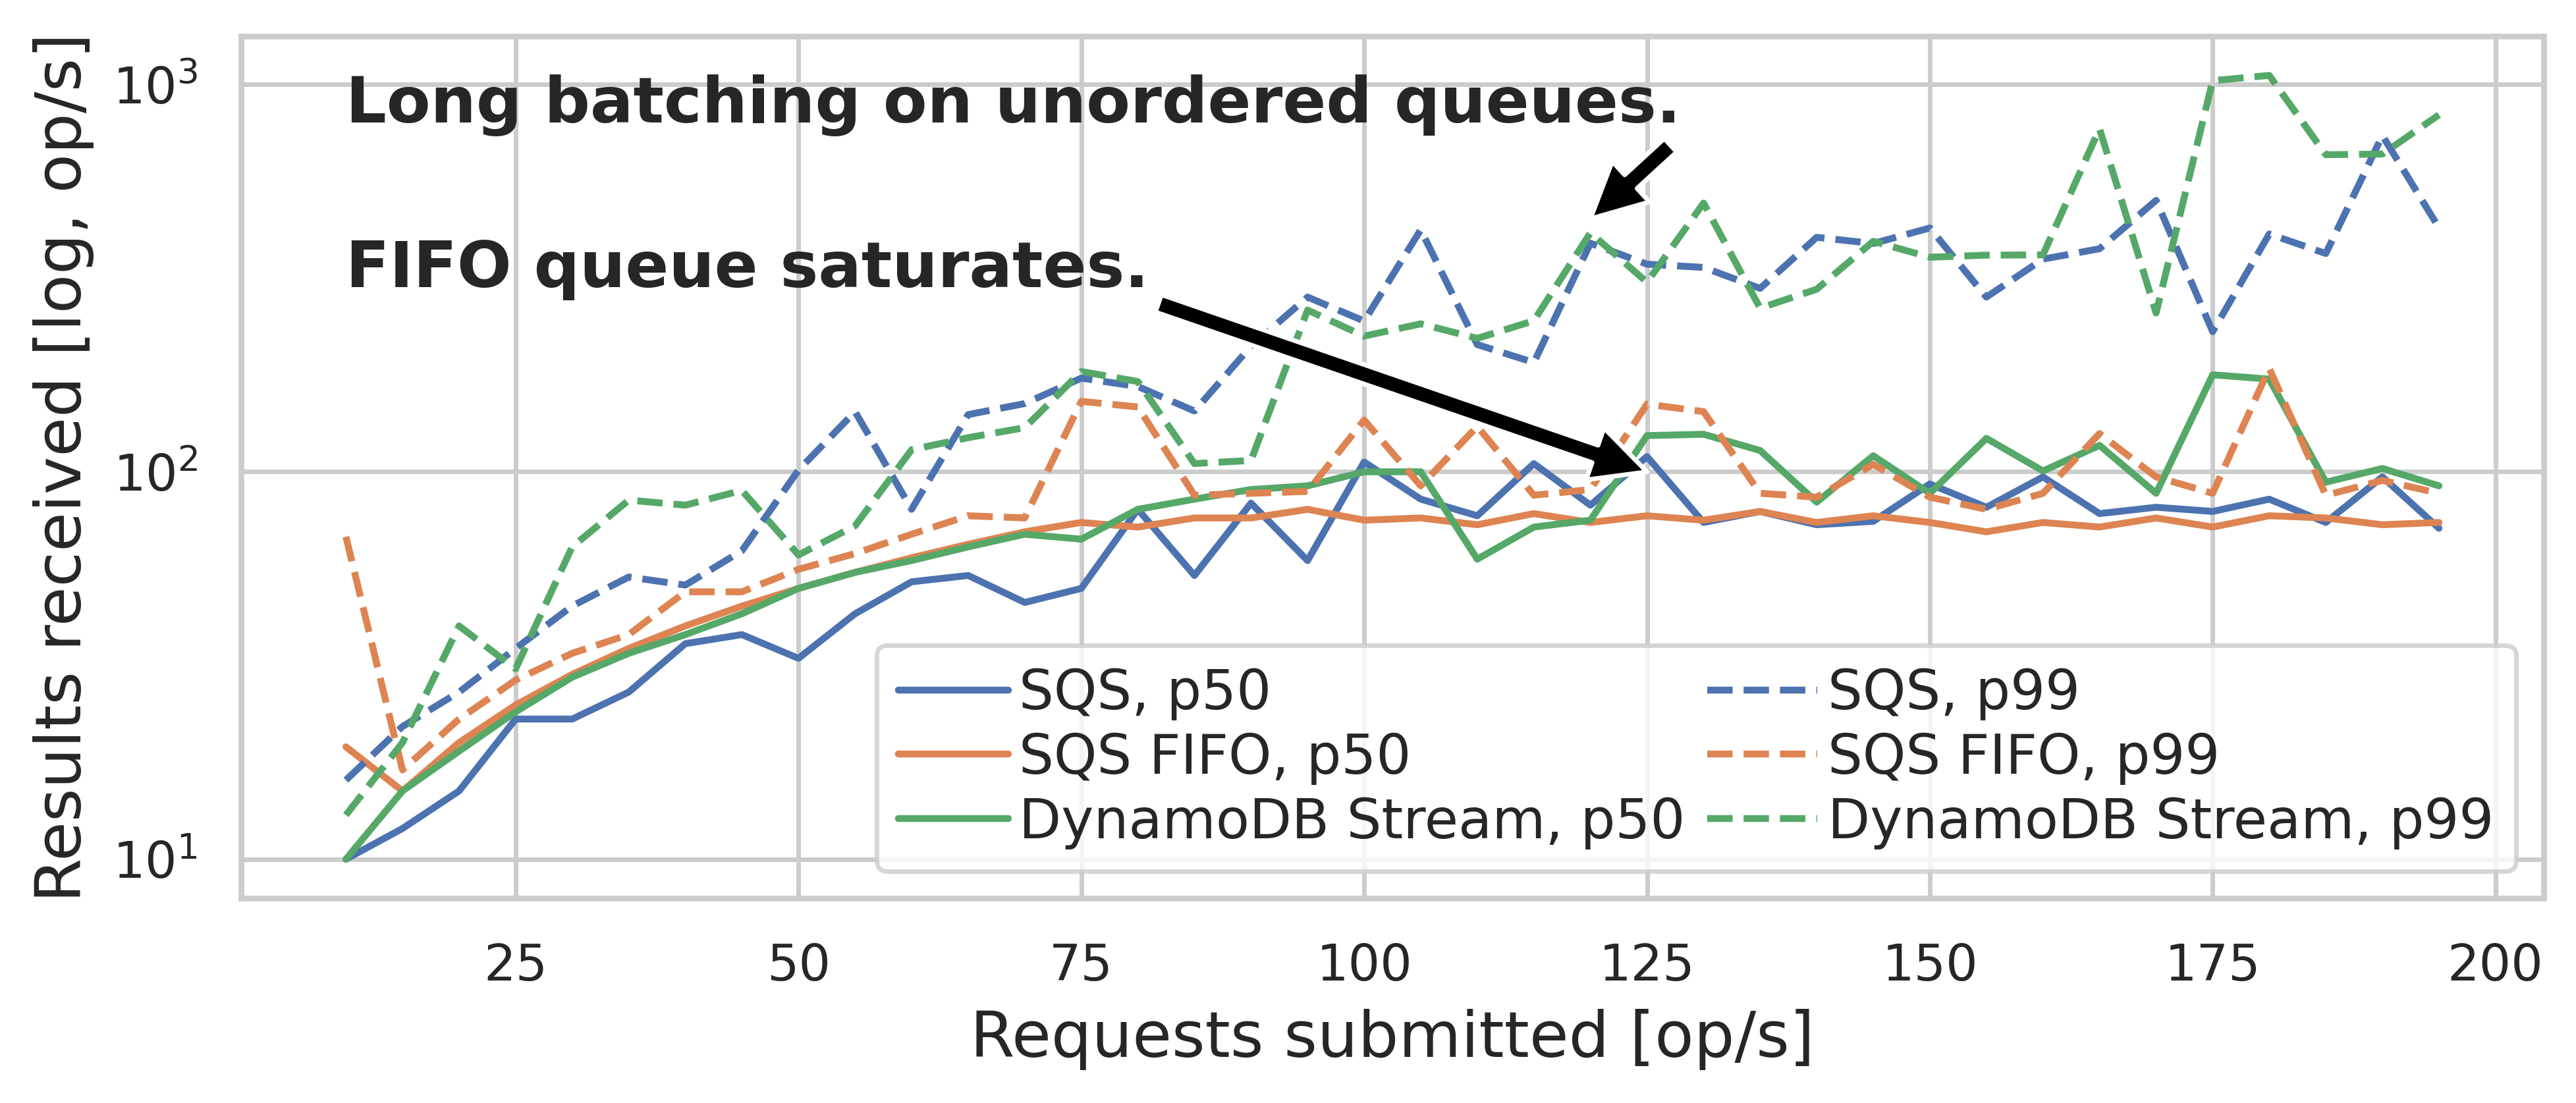

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,3.5)})
sns.set_style("whitegrid")

def p50_estimator(x):                                            
    return np.percentile(x, 50)           

sns.lineplot(data=processed_windows.loc[processed_windows['type'] == 'median'], x="rps", y="val", hue="queue")
ax = sns.lineplot(data=processed_windows.loc[processed_windows['type'] == 'p99'], x="rps", y="val", hue="queue",linestyle='--')


#plt.grid(axis='y')
#plt.title(benchmark, fontsize=20)
plt.xlabel('Requests submitted [op/s]',fontsize=14)
plt.ylabel('Results received [log, op/s]', fontsize=14)
#plt.xticks(x)
# plt.ylim(ymin=0)
#plt.legend(ncol=3)

ax.lines[-1].set_linestyle('--')
ax.lines[-2].set_linestyle('--')
ax.lines[-3].set_linestyle('--')

handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[0:6],
    ['SQS, p50', 'SQS FIFO, p50', "DynamoDB Stream, p50",'SQS, p99', 'SQS FIFO, p99', "DynamoDB Stream, p99"],
    loc=4,
    handletextpad=0.2,labelspacing=0.2,columnspacing=0.4, ncol=2, fontsize=12)

ax.annotate(
    'Long batching on unordered queues.',
    xy=(120, 450), xytext=(10, 800),
    fontsize=14, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0)
)
ax.annotate(
    'FIFO queue saturates.',
    xy=(125, 100), xytext=(10, 300),
    fontsize=14, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0)
)
plt.yscale('log')


plt.rcParams['figure.dpi'] = 500
plt.tight_layout()

plt.savefig("queue_throughput.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)
#plt.legend()
#plt.savefig(os.path.join(usm_data_dir, machine, "plots", f'time_{benchmark}.pdf'))

#plt.show()

In [49]:
print(df)
data = []
for typ in ['sqs', 'sqs_fifo', 'dynamo']:
    x = df.loc[(df['type'] == 'rtt') & (df['queue'] == typ)]
    
    print("Median record size", typ, x.loc[(x['events'] > 0)]['events'].median())
    print("Max record size", typ, x.loc[(x['events'] > 0)]['events'].median())

                               Unnamed: 0     timestamp       idx     queue  \
new_timestamp                                                                 
2022-02-06 19:31:49.748267264           0  1.644176e+09  0ba82f93    dynamo   
2022-02-06 19:31:49.820467712           1  1.644176e+09  73b82f3a    dynamo   
2022-02-06 19:31:49.920738560           2  1.644176e+09  f0ef5a42    dynamo   
2022-02-06 19:31:50.021791744           3  1.644176e+09  4eba70d9    dynamo   
2022-02-06 19:31:50.121024768           4  1.644176e+09  e0452ba1    dynamo   
...                                   ...           ...       ...       ...   
2022-02-06 18:42:00.961026816        1945  1.644173e+09     40795  sqs_fifo   
2022-02-06 18:42:00.994072064        1946  1.644173e+09     40796  sqs_fifo   
2022-02-06 18:42:00.994842112        1947  1.644173e+09     40797  sqs_fifo   
2022-02-06 18:42:00.995575296        1948  1.644173e+09     40798  sqs_fifo   
2022-02-06 18:42:00.996371456        1949  1.644173e